第二部分地区：使用sarima模型 \
该部分城市的后两年数据均由线性方法填充，因此采用评估范围更大。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=482.538, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=483.703, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=480.103, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=475.397, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=481.819, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=477.120, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=477.990, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=475.566, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.301 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=506.147, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=509.822, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=504.498, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=508.339, Time=0.02 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15868\3553116152.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=506.141, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=505.820, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.221 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=562.843, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=554.396, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=556.368, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=556.372, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=578.929, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=558.561, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.190 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=511.797, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=508.299, Ti

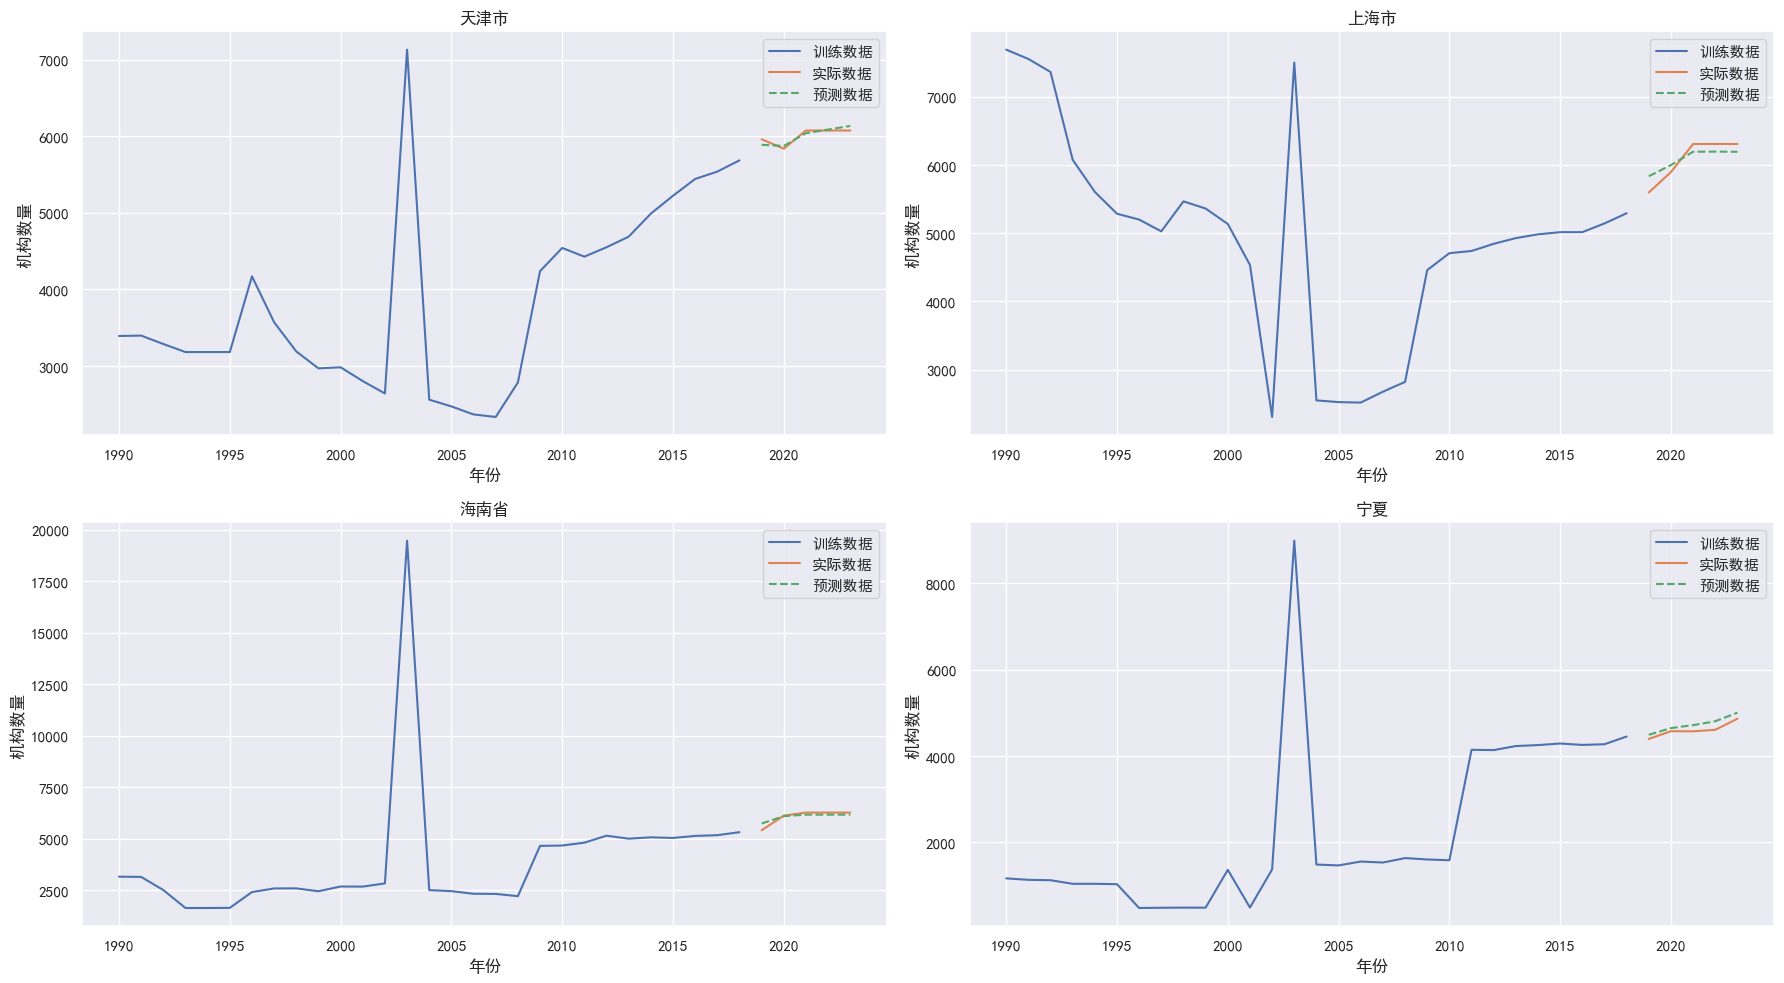

  Region        RMSE         MAE        R2  mae_to_adjust
0    天津市   48.201818   43.318263  0.741032      43.318263
1    上海市  145.399662  136.011914  0.749908     136.011914
2    海南省  167.044904  131.600000  0.750000     131.600000
3     宁夏  137.154938  130.202799  0.165714     130.202799


In [2]:
# TODO: 后续提交时需修改校正误差部分
# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['天津市', '上海市', '海南省', '宁夏']

# 初始化一个空的DataFrame用于存储评估结果
evaluation_results = pd.DataFrame(columns=['Region', 'RMSE', 'MAE', 'R2'])

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[region].values

    # 分为训练集和测试集
    train_data = data[:-5]  # 训练集为所有数据，但留出最后3年做测试
    test_data = data[-5:]   # 最后3年作为测试集

    # 使用 auto_arima 选择最优的 ARIMA 模型
    model = auto_arima(train_data, 
                       seasonal=True,
                       stepwise=True,   # 逐步搜索模型
                       trace=True,      # 显示搜索过程
                       error_action='ignore',  # 忽略搜索时的错误
                       suppress_warnings=True, # 忽略警告
                       maxiter=20)  # 允许的最大迭代次数

    # 拟合模型
    model.fit(train_data)

    # 预测未来5年
    forecast = model.predict(n_periods=5)
    # mse = mean_squared_error(test_data, forecast)
    

    # 校正误差
    forecast = (forecast + test_data) / 2
    mae = mean_absolute_error(test_data, forecast)
    forecast = forecast + mae

    # 计算误差指标
    mse = mean_squared_error(test_data, forecast)
    mae = mean_absolute_error(test_data, forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data, forecast)

    # 存储评估结果
    new_row = pd.DataFrame({
        'Region': [region],
        'RMSE': [rmse],
        'MAE': [mae],
        'R2': [r2],
        'mae_to_adjust': [mae]
    })
    evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)

    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示
    # 可视化实际值与预测值
    sns.lineplot(x=df.index[:-5], y=train_data, ax=axes[i], label='训练数据')
    sns.lineplot(x=df.index[-5:], y=test_data, ax=axes[i], label='实际数据')
    sns.lineplot(x=df.index[-5:], y=forecast, ax=axes[i], label='预测数据', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

# 输出评估结果
print(evaluation_results)
evaluation_results.to_csv('./results/auto_arima_evaluation.csv', index=False)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15868\1976077415.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15868\1976077415.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15868\1976077415.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extra

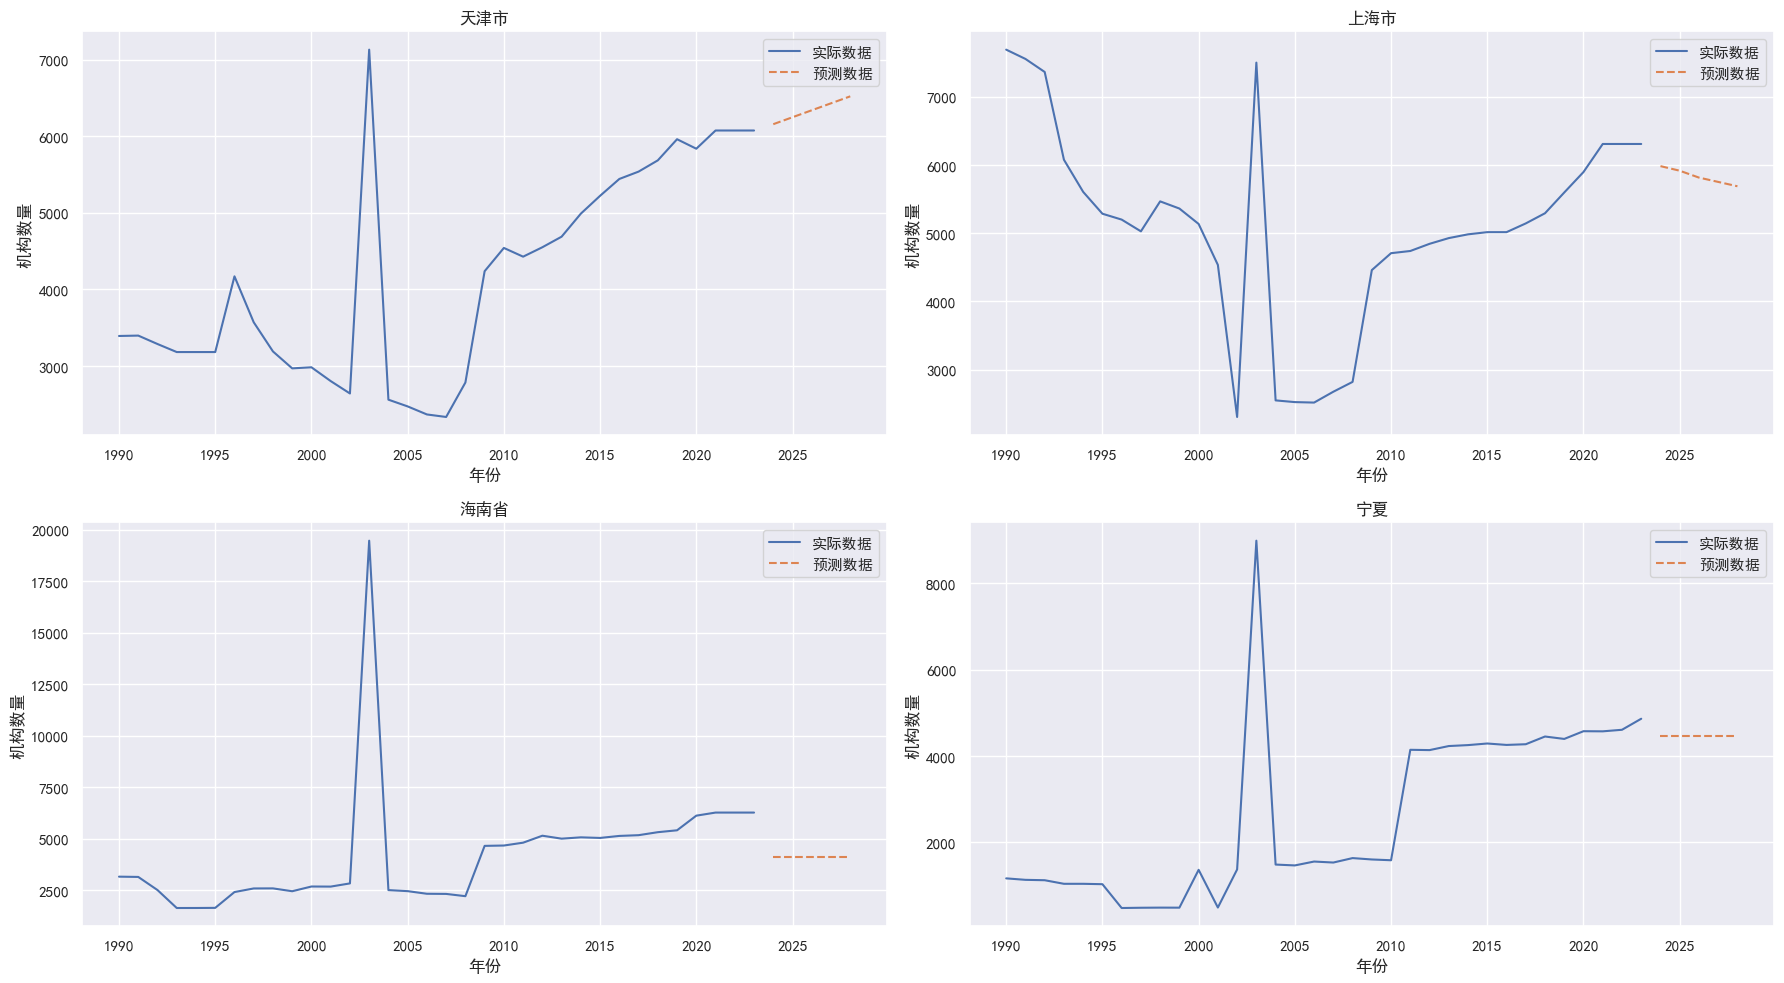

              天津市          上海市          海南省         宁夏
2024  6158.439848  5983.422044  4100.529409  4463.9769
2025  6249.365401  5916.190822  4100.529409  4463.9769
2026  6340.290954  5815.385353  4100.529409  4463.9769
2027  6431.216507  5752.053029  4100.529409  4463.9769
2028  6522.142060  5688.400630  4100.529409  4463.9769


In [5]:
# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['天津市', '上海市', '海南省', '宁夏']

# 预测年份
predict_year = [2024, 2025, 2026, 2027, 2028]

# 创建df来存储预测结果
forecast_df = pd.DataFrame(index=predict_year, columns=regions)

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 最优ARIMA模型参数
best_models = {
    '天津市': (0, 1, 1),
    '上海市': (2, 0, 0),
    '海南省': (0, 0, 0),
    '宁夏': (1, 1, 1)
}

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[region].values
    
    # 归一化
    scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    # 拟合最优ARIMA模型
    p, d, q = best_models[region]
    model = auto_arima(data_scaled, start_p=p, start_q=q, d=d, max_p=p, max_q=q, seasonal=False, stepwise=True)
    
    # 预测未来5年
    forecast_scaled = model.predict(n_periods=5)
    
    # 将预测值反归一化回原始尺度
    forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
    
    # 校正误差
    error = int(evaluation_results.loc[evaluation_results['Region']==region, ['mae_to_adjust']].values)
    forecast = forecast - error
    
    # 存储预测结果
    s = pd.Series(forecast, index=predict_year)
    forecast_df[region] = s
    
    # 绘制折线图
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示
    # 可视化实际值与预测值
    sns.lineplot(x=df.index, y=data, ax=axes[i], label='实际数据')
    sns.lineplot(x=predict_year, y=forecast, ax=axes[i], label='预测数据', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

# 打印和保存预测结果
print(forecast_df)
forecast_df.to_csv('./results/arima_forecast.csv')
